# Random Forests and San Francisco Crime dataset

Welcome to this week`s session. We will implement Random Forests and use it to predict the kind of crime using the San Francisco Crime dataset.

You can find the San Francisco Crime dataset and a corresponding tutorial challenge on Kaggle at https://www.kaggle.com/c/sf-crime#description

One possible solution to the challenge can be found at https://github.com/TobiasWeis/kaggle_sf_crime. We adapt it here.

The RandomForest implementation is based on fastai`s machine learning course (see http://course18.fast.ai/lessonsml1/lesson7.html for the lecture and for the code: https://github.com/fastai/fastai/blob/master/courses/ml1/lesson3-rf_foundations.ipynb ). The license for the RandomForest code can be found at: https://github.com/fastai/fastai/blob/master/LICENSE

## San Francisco Crime
We will now apply our new knowledge about random forests to a new dataset: 
https://www.kaggle.com/c/sf-crime#description.
So, go to the kaggle website, download the data, then click on the upload button in colab and upload it.

In [32]:
!pip install wget

import wget

# download the data
data = wget.download('https://github.com/TobiasWeis/kaggle_sf_crime/raw/master/data/kaggle_data.zip')

In [2]:
import zipfile

# extract the zipfile
zip_ref = zipfile.ZipFile('kaggle_data.zip', 'r')
zip_ref.extractall('.')
zip_ref.close()

In [28]:
import pandas as pd
import numpy as np
import time

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

"""
    Load the datafiles (assuming its in the same directory as this notebook)
    
    Transform the features:
    - Extract datetime-features using pandas
    - Transform string variables to integers (same string -> same integer)
    - Calculate whether an address is a street corner by searching for the "/" character
    
"""
def load_csv(fname):
    df = pd.read_csv(fname, parse_dates=['Dates'])

    df['Hour'] = df.Dates.dt.hour
    df['Month'] = df.Dates.dt.month
    df['Year'] = df.Dates.dt.year
    df['DayOfWeek'] = df.Dates.dt.dayofweek
    df['DayOfYear'] = df.Dates.dt.dayofyear

    # add an attribute PdDistrict_num, which transforms PdDistrict-strings to integers, 
    # e.g. 'NORTHERN' to 4
    df['PdDistrict_num'] = df.PdDistrict.astype('category').cat.codes.astype('int')

    # if there is a / in the address, then it is a street corner
    df['StreetCorner'] = df['Address'].apply(lambda x: 1 if '/' in x else 0)
    
    # check for the outliers in the position, e.g. north pole instead of san francisco
    df = df[np.abs(df.X-df.X.mean())<=(3*df.X.std())]
    
    return df
    
df = load_csv('train.csv')
df_test = load_csv('test.csv')

In [8]:
# visualize the available attributes of the dataset and their form
df[:5]

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Hour,Month,Year,DayOfYear,PdDistrict_num,StreetCorner
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,2,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,23,5,2015,133,4,1
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,2,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,23,5,2015,133,4,1
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,2,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,23,5,2015,133,4,1
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,2,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,23,5,2015,133,4,0
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,2,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,23,5,2015,133,5,0


In [9]:
# check how many different crime categories are present in the dataset
unique_categories = df["Category"].unique()
print('number of crime categories to predict:')
len(unique_categories)

number of crime categories to predict:


39

In [10]:
# add an attribute Category_num with numerical values for categories instead of string names
df['Category_num']=df['Category'].astype('category').cat.codes
# the string array assigns numerical categories to their string labels
categories = df['Category'].astype('category').cat.categories

<AxesSubplot:xlabel='X', ylabel='Y'>

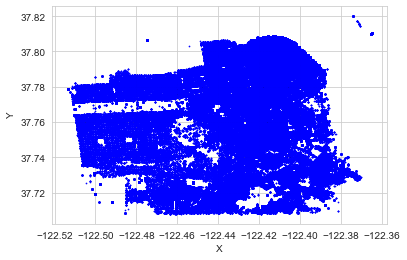

In [11]:
# visualize the locations of all crime categories

df.plot.scatter(x='X',y='Y',s=0.5,c='blue')

<AxesSubplot:title={'center':'Number of crimes per PdDistrict'}>

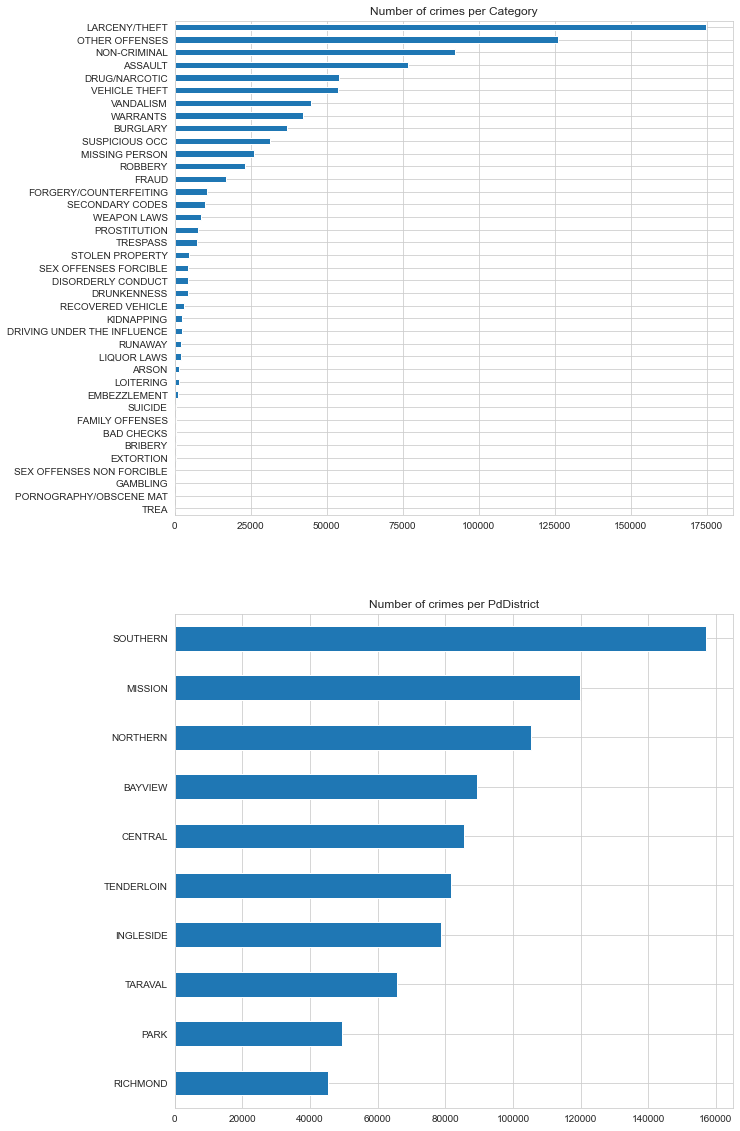

In [12]:
# visualize the number of crimes per Category and PdDistrict
# hint: https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html

import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10,20))
fig.add_subplot(211)
df["Category"].value_counts(ascending=True).plot(kind="barh", title="Number of crimes per Category")
fig.add_subplot(212)
df["PdDistrict"].value_counts(ascending=True).plot(kind="barh", title="Number of crimes per PdDistrict")


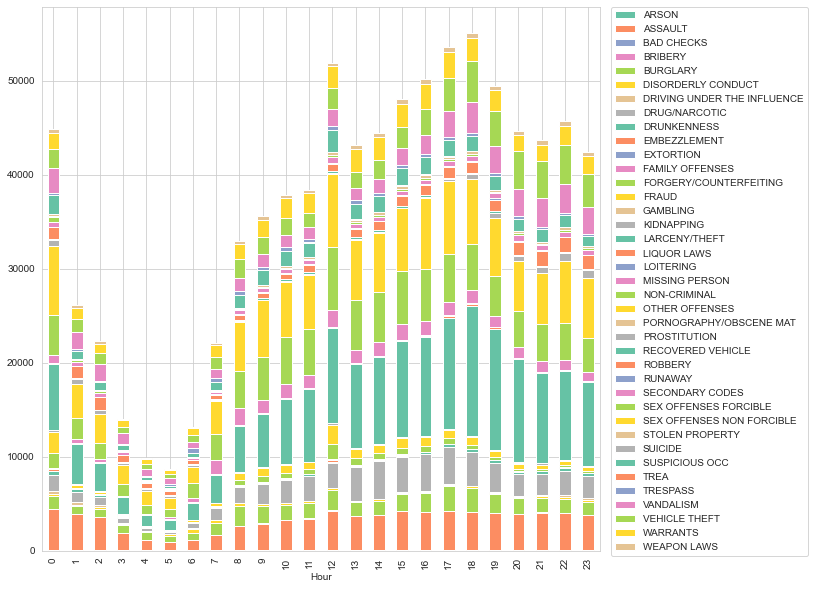

In [13]:
# visualize the relationship between the hour at which the crime has been committed and the crime category
import seaborn as sns

by_param = df.groupby(['Hour', 'Category'])
# compute the sizes (number of elements) for the grouped data
table = by_param.size()
d2table = table.unstack()
d2table.plot(kind='bar', stacked='True',figsize=(10,10),color=sns.color_palette('Set2', len(np.unique(df.Category))))
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

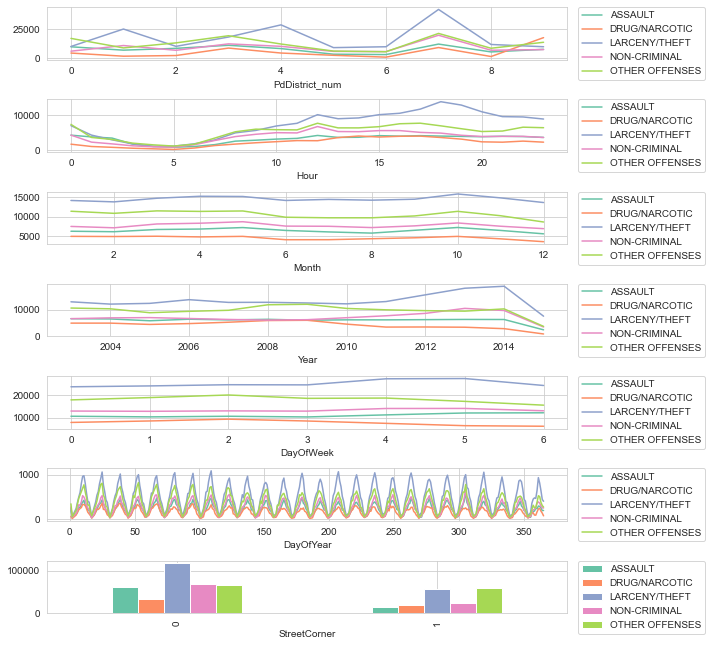

In [14]:
import math
top_cats = ["LARCENY/THEFT", "OTHER OFFENSES", "NON-CRIMINAL", "ASSAULT", "DRUG/NARCOTIC"]
fig = plt.figure()
features = ["PdDistrict_num", "Hour", "Month", "Year","DayOfWeek", "DayOfYear", "StreetCorner" ]

nrows = 8
ncols = 1

for i,feat in enumerate(features):
    ax = fig.add_subplot(nrows, ncols, i+1)
    
    by_param = df[df.Category.isin(top_cats)].groupby([feat, 'Category'])
    table = by_param.size()
    d2table = table.unstack()
    
    if feat == 'StreetCorner':
        d2table.plot(ax=ax, figsize=(10,10), kind='bar', color=sns.color_palette('Set2', len(np.unique(df.Category))))
    else:
        d2table.plot(ax=ax, figsize=(10,10), color=sns.color_palette('Set2', len(np.unique(df.Category))))
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

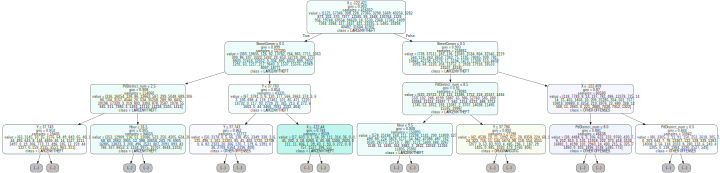

In [20]:
'''
Apply previously acquired knowledge to the given data, to summarize:
1. Split the train data into train and test (the test subset is used to validate the results)
2. Choose features on which to train and get the data from those features
3. train a RandomForestClassifier (to speed up, restrict max_depth to e.g. 5)
4. visualize the graph
5. check the accuracy of the predictions on the X_test

Modify the procedure to incorporate log loss:
1. use another prediction function instead of clf.predict(), 
  which gives you class probabilities instead of a fixed class label 
2. instead of the accuracy, compute log_loss 
  (hint: use https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)
'''

import pydotplus

# select 75 percent of data as train and 25 as test
df['train'] = np.random.uniform(0,1,len(df)) <= .75
train, test = df[df.train], df[~df.train]

# use some features to test, for example
features = ["X", "Y", "Hour", "StreetCorner", "DayOfWeek", "PdDistrict_num"]

# define x_train, y_train, x_test, y_test
x_train = train[features]
y_train = train.Category

x_test = test[features]
y_test = test.Category

clf = RandomForestClassifier(n_estimators=15, max_depth=10, n_jobs=4)
clf.fit(x_train, y_train)
preds = clf.predict(x_test)

import graphviz 
dot_data = tree.export_graphviz(clf.estimators_[0], out_file=None, 
                         max_depth=3,
                         feature_names=features,  
                         class_names=categories,  
                         filled=True, rounded=True,  
                         special_characters=True)  
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"10,10!"')
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

6. check the accuracy and the logarithmic loss of the predictions on the x_test,
for the comparison of the two, check out: http://wiki.fast.ai/index.php/Log_Loss,
check out also http://cs229.stanford.edu/proj2016/report/HaleLiu-SanFranciscoCrimeClassification.pdf, who have, among other thins, tried logistic regression to solve the challenge ;)

Is the accuracy value that you see high or low? Why do you think this is so?


In [21]:
preds = clf.predict(x_test)
#pd.crosstab(test.Category, labels[preds], rownames=['Actual categories'], colnames=['Predicted categories'] )

from sklearn.metrics import accuracy_score
# calculate the accuracy for the test data
# hint: you need preds - predicted categories, as well as the ground truth categories
accuracy = accuracy_score(y_test, preds, normalize=True)

# instead of the category itself, set preds to the predicted probabilities for each class
preds = clf.predict_proba(x_test)

# why does preds has this shape?
print('shape of predict_proba(x_test)')
print(preds.shape)

from sklearn.metrics import log_loss
# calculate logistic loss or cross-entropy loss, set normalize=True
# the base of the logarithm for this function is e (natural logarithm)
log_loss = log_loss(y_test, preds, normalize=True)

print('accuracy: {0:1f}, log_loss: {1:2f}'.format(accuracy, log_loss))

shape of predict_proba(x_test)
(220144, 39)
accuracy: 0.266221, log_loss: 2.432561


In [22]:
# for comparison reasons, fill predictions with 1./num_classes and compute the log_loss outcome
# this tells you what the log_loss is when each class is equally probable 
import numpy as np

num_classes = len(df.Category.unique())
preds = np.full((len(test),num_classes),1./num_classes)

from sklearn.metrics import log_loss
log_loss(y_test, preds, normalize=True)

3.6635616461296467

In [23]:
"""
    Lets define the classifiers we want to test,
    as well as the subsets of features we are interested in
"""
classifiers = [
                tree.DecisionTreeClassifier(random_state=1337),
                RandomForestClassifier(random_state=1337)
                ]

# select your feature sets to test, e.g. ["X", "Y"]

feature_sets = [
                ["X", "Y"],
                ["X", "Y", "Hour"],
                ["X", "Y", "Hour", "StreetCorner", "DayOfWeek"],
                ['X','Y','PdDistrict_num']
               ]

In [26]:
"""
    First try: run the classifiers with their default parameters on all feature sets
               using a basic train/test split of the data
    Hint #1: use https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    Hint #2: do not forget to stratify based on df.Category
"""

for clf in classifiers:
    for features_to_use in feature_sets:
        # split df (the train set) into train and test(validation), compute prediction and evaluate log_loss
        x_train, x_test, y_train, y_test = train_test_split(df[features_to_use], df.Category, stratify=df.Category, train_size=0.8, test_size=0.2)
        //TODO: train
        preds = //TODO calculate prediction probabilities (!)
        print(clf.__class__.__name__," on Feature set ",features_to_use,": ",log_loss(y_test, preds))
    print

DecisionTreeClassifier  on Feature set  ['X', 'Y'] :  6.163321755379823
DecisionTreeClassifier  on Feature set  ['X', 'Y', 'Hour'] :  16.55454924735346
DecisionTreeClassifier  on Feature set  ['X', 'Y', 'Hour', 'StreetCorner', 'DayOfWeek'] :  21.65325363945956
DecisionTreeClassifier  on Feature set  ['X', 'Y', 'PdDistrict_num'] :  6.166805842108435
RandomForestClassifier  on Feature set  ['X', 'Y'] :  5.565151190596928
RandomForestClassifier  on Feature set  ['X', 'Y', 'Hour'] :  9.12838498624278
RandomForestClassifier  on Feature set  ['X', 'Y', 'Hour', 'StreetCorner', 'DayOfWeek'] :  8.354070194493149
RandomForestClassifier  on Feature set  ['X', 'Y', 'PdDistrict_num'] :  5.630851509217896


In [30]:
"""
    Observations:
        - RandomForrest generally performed better than the DecisionTree
        - Prediction-quality got less with increasing number features using the default classifier parameters
        
    Intuition: Curse of dimensionality, our models are not complex enough
    
    Lets search over additional hyperparameters that might help:
    ( if we have absolutely no clue about how the model works, 
      look up possible model-parameters in the sklearn-documentation,
      spend some time enumerating coarse parameter ranges that work using gridsearch )
      
    In this case, we have an intuition about what might work, so we can restrict the parameter space:
    - evaluate only RandomForrest (was generally better) to save some time
    - deeper trees will probably allow us to handle more feature combinations
    - min_samples_leaf might counter overfitting
    - num_estimators (for RandomForrests) will create more trees
    
"""
param_dict_rf = {
                "max_depth": [3,6],
                "min_samples_leaf" : [30, 35, 50],
                "n_estimators" : [10, 15, 20],
                }

for features_to_use in feature_sets:
    ss = time.time()
    # use RandomizedSearchCV with neg_log_loss as the scoring function
    # and RandomForestClassifier, give it param_dict_rf as param_distributions
    # set n_iter = 10
    random_search = RandomizedSearchCV(RandomForestClassifier(random_state=1337, n_jobs=4), 
                                       param_distributions=param_dict_rf, 
                                       n_iter=1, 
                                       scoring='neg_log_loss',
                                       cv=3
                                       )

    random_search.fit(df[features_to_use], df.Category)
    print("==================")    
    print("Took ", time.time() - ss)
    print(random_search.best_estimator_)
    print(-random_search.best_score_)
    print(features_to_use)

Took  22.901700258255005
RandomForestClassifier(max_depth=6, min_samples_leaf=50, n_estimators=10,
                       n_jobs=4, random_state=1337)
2.547357173588859
['X', 'Y']
Took  21.81666660308838
RandomForestClassifier(max_depth=6, min_samples_leaf=30, n_estimators=15,
                       n_jobs=4, random_state=1337)
2.55082144069902
['X', 'Y', 'Hour']
Took  27.63230609893799
RandomForestClassifier(max_depth=6, min_samples_leaf=35, n_estimators=20,
                       n_jobs=4, random_state=1337)
2.5185033918051487
['X', 'Y', 'Hour', 'StreetCorner', 'DayOfWeek']
Took  25.577889680862427
RandomForestClassifier(max_depth=6, min_samples_leaf=30, n_estimators=20,
                       n_jobs=4, random_state=1337)
2.553201568496536
['X', 'Y', 'PdDistrict_num']


In [31]:
"""
    Optional:
    Create submission file using the best classifier
    This time we fit on the complete training set.
    Compress the resulting csv-file using zip before uploading
"""
be = random_search.best_estimator_
use_these_features = ['X', 'Y', 'Hour', 'StreetCorner', 'DayOfWeek'] # adapt this to your best feature combination

be.fit(df[use_these_features], df.Category)
submission_preds = be.predict_proba(df_test[use_these_features])
submission = pd.DataFrame(submission_preds, columns=categories)
submission.to_csv('submission.csv', index=True, index_label='Id')